## DV1597 Assignment 1

Namn

***

#### Initialize

In [161]:
# Import packages
import pandas as pd
import matplotlib.pyplot as mpl # Version 3.8.4
import matplotlib.dates as mdates
import seaborn as sb
import numpy as np
import scipy.stats as stats
import calendar

In [162]:
# Load dataset
df_original = pd.read_csv('SMHI_Data.csv')
df_original

,Datum,Tid (UTC),Lufttemperatur
0,2010-03-01,00:00:00,2.0
1,2010-03-01,01:00:00,2.2
2,2010-03-01,02:00:00,2.2
3,2010-03-01,03:00:00,1.7
4,2010-03-01,04:00:00,1.7
...,...,...,...
122851,2024-01-01,02:00:00,3.9
122852,2024-01-01,03:00:00,3.9
122853,2024-01-01,04:00:00,3.7
122854,2024-01-01,05:00:00,3.6


***

### Part 1

#### Q1
**Explain the data cleaning steps you consider for analyzing the provided dataset. You must motivate and describe why, how, and in which order you are going to apply the selected steps to the dataset. Note that you should consider applying your proposed data cleaning steps on the dataset to answer Q2-Q11.**

Firstly we will look at the dataset and remove all duplicates in it. Then we want to remove all the missing values. Some missing values have an entry in the csv-file, but is missing the temperature data, while some timestamps are not found at all in the data. The strategy here is to insert all timestamps that are missing, with no temperature data, and then add an estimated temperature for every missing instance.

***

#### Q2
**Does the dataset contain any missing values? If so, how many in both absolute terms and percentages? Reflect on the number of missing values. Do you regard it as much or not?**

Yes, yes.

***

#### Q3
**Which strategy was used for handling the missing values? Motivate why you consider the selected strategy the most suitable for this task.**

Good strategy.

***

### Find missing timestamps

Out first step is to look at every row in the dataset, and find if any timestamp is missing from it. For example if for a date, the time 00:00:00 and 02:00:00 exists, but not 01:00:00. We also add all the timestamps that are missing to the dataframe.

In [163]:
df = df_original.copy()

# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Convert date and time to one datetime column
df['Time'] = df['Datum']+" "+df['Tid (UTC)']
df['Time'] = pd.to_datetime(df['Time'])

# Remove old time data
df = df.drop('Datum', axis=1)
df = df.drop('Tid (UTC)',axis=1)

# Create a date range from first to last timestamp
start = df.iloc[0]
end = df.iloc[len(df)-1]
dates = pd.date_range(start=start['Time'], end=end['Time'], freq='1h')

# Count missing timestamps
missing = len(dates)-len(df)
print("Missing timestamps:",missing)

# Add missing timestamps
df = df.set_index('Time').reindex(dates).reset_index()
df.columns = ['Time', 'Lufttemperatur']

Missing timestamps: 694


We found and added a total of 694 missing timestamps.

### Missing temperature values
Now we look for instances where the temperature data is missing. Then we estimate them.

In [164]:
# Count NaN values for each column
na_values = df.isna().sum()
na_temp = na_values['Lufttemperatur']
na_p = round(100*(na_temp/len(df)),2)

print("NaN temperatures:",na_temp)
print("NaN temperatures percentage:",na_p, '%')

# Estimating missing values
df['Lufttemperatur'] = df['Lufttemperatur'].interpolate().round(1)

NaN temperatures: 7931
NaN temperatures percentage: 6.54 %


***
#### Q4

**Calculate the following statistics for the air temperature values in the dataset: minimum value, maximum value, sample mean, Q1/Q2/Q3 quartiles, sample standard deviation, 95% confidence interval of the mean**

In [165]:
temps = df['Lufttemperatur']

# Min, max, mean
print("Min:",temps.min())
print("Max:",temps.max())
mean = round(temps.mean(),3)
print("Mean:", mean)

# Quartiles and standard deviation
print("\nQuartiles:")
print("Q1 (25%):",temps.quantile(0.25))
print("Q2 (50%):",temps.quantile(0.5))
print("Q3 (75%):",temps.quantile(0.75))
std = round(temps.std(),3)
print("\nStandard deviation:",std)

# 95% confidence interval: mean +- margin of error
# margin of error = critical t-value * standard deviation / sqrt(sample size)
critical_t_value = stats.t.ppf(0.05 / 2, temps.count() - 1)
margin_of_error = critical_t_value * std / temps.count() ** 0.5
print("\nConfidence interval: ", mean, u"\u00B1", abs(margin_of_error).round(3))

Min: -19.2
Max: 38.6
Mean: 9.441

Quartiles:
Q1 (25%): 4.1
Q2 (50%): 9.1
Q3 (75%): 15.3

Standard deviation: 6.981

Confidence interval:  9.441 ± 0.039


***
#### Q5
**Plot all available air temperature data as a line plot with dates on the x-axis.**


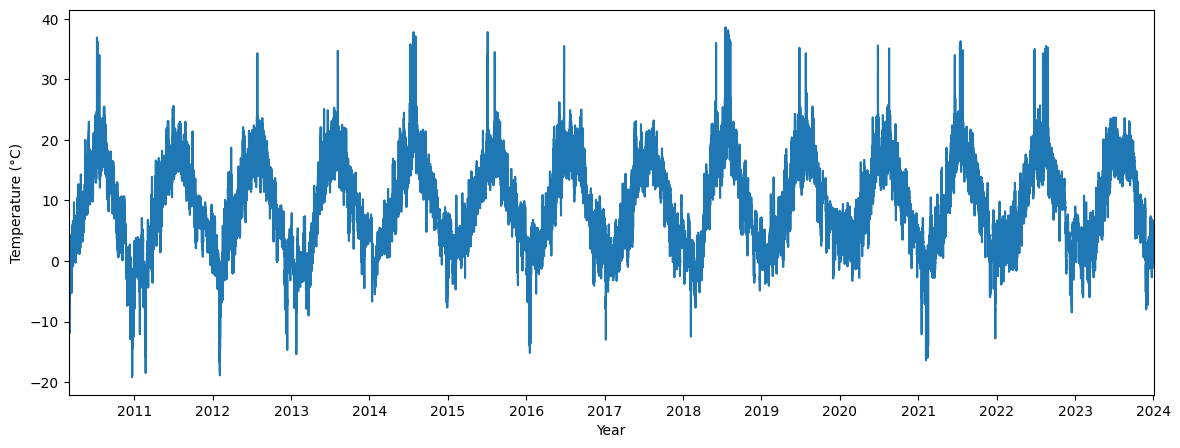

In [166]:
# Create plot
fig = mpl.figure(figsize=(14, 5))
ax = fig.add_subplot()
ax.plot(df['Time'],df['Lufttemperatur'])

# Set x-axis limits and x-axis labels
ax.set_xlim(df.iloc[0]['Time'], df.iloc[-1]['Time'])
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')

# X-tick every year
ax.xaxis.set_major_locator(mdates.YearLocator())

mpl.show()

***

#### Q6
**Rank the overall temperature per month, sort from the coldest to the warmest. List the top ten (10) coldest months in the dataset. Format the output as: YEAR/Month: temp, e.g.“2010/January: -5.0”**

In [167]:
# Create a slice that includes all complete months
df_6 = df.loc[0:121295].copy()
df_6.set_index('Time', inplace=True)

# Calculate average temperature for each month
df_avg = df_6.groupby(pd.Grouper(freq='ME')).mean().reset_index().round(1)
df_avg['Time'] = df_avg['Time'].apply(lambda x: str(x.year)+'/'+calendar.month_name[x.month])

# Sort values and print
df_avg = df_avg.sort_values('Lufttemperatur').reset_index(drop=True)

# Add output column
df_avg['Lufttemperatur'] = df_avg['Lufttemperatur'].astype(str) 
df_avg['Month and temperature'] = df_avg['Time']+': '+ df_avg['Lufttemperatur']

# Print
print("Coldest months (°C):")
print(df_avg['Month and temperature'].head(10).to_string(index=False))

Coldest months (°C):
2010/December: -3.8
2011/February: -1.5
2012/February: -1.4
2021/February: -1.0
 2016/January: -1.0
2018/February: -0.9
   2013/March: -0.8
 2013/January: -0.6
2012/December: -0.6
2013/February: -0.4


### Part 2 (D)

Q7. Which distribution is suitable to consider to fit the air temperature data? How well does the data follow that distribution given some measure, e.g., p-value?

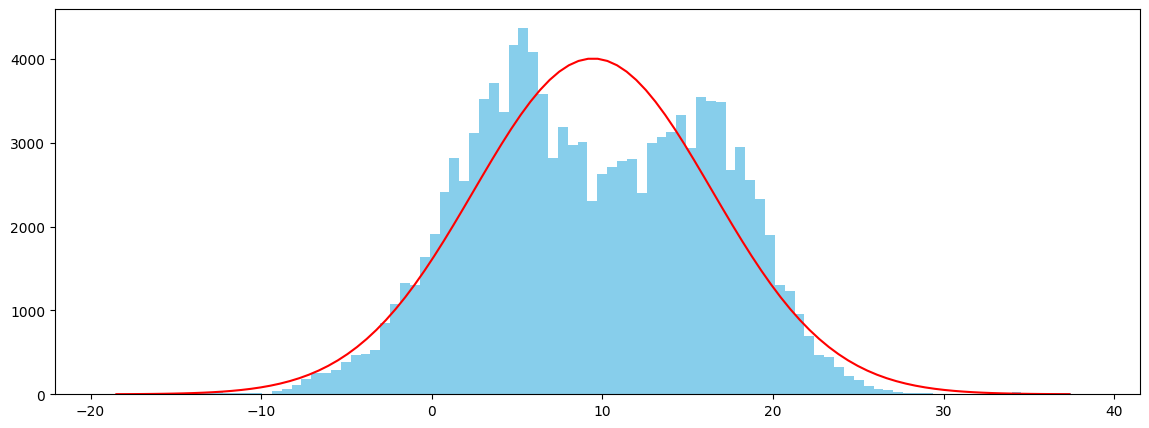

In [168]:
fig = mpl.figure(figsize=(14,5))
ax = fig.add_subplot()
num_bins = 100
ax.hist(df['Lufttemperatur'], bins=num_bins, label="Datatata", linewidth=3, color='skyblue')

bin_width = (df['Lufttemperatur'].max() - df['Lufttemperatur'].min()) / num_bins
mean = df['Lufttemperatur'].mean()
std = df['Lufttemperatur'].std()

x = np.linspace(mean - 4*std, mean + 4*std, 100)

mpl.plot(x, stats.norm.pdf(x, mean, std)*len(df)*bin_width, color='red')
mpl.show()

Normally disitributed? no

***

### Part 3 (C)

### Q8
Do you regard any of the air temperature measures in the dataset to be extreme values/outliers? If so, how many values? Motivate why you
consider these values as anomalies.

In [169]:
# Z-score test
mean = df['Lufttemperatur'].mean()
std = df['Lufttemperatur'].std()

# Calculate z-score
z_score = (df['Lufttemperatur'] - mean) / std

# Set threshold of 3 standard deviations
threshold = 3

# Save outliers and print
outliers = df[abs(z_score) > threshold]

print("Outliers: ", len(outliers))


# Code for detecting anomalies
anomalies = []
anomalies_t = []
prev_value = 2 # first value
rows = len(df['Lufttemperatur']) - 1

# Compare every temperature to the previous and the next to see if it sticks out
for i in range(rows):
    if i != rows:
        next_value = df.iat[i+1, 1]

    if abs(df.iat[i, 1] - (prev_value + next_value) / 2) > 7:
        anomalies.append(df.iat[i, 1])
        anomalies_t.append(df.iat[i, 0])

    prev_value = df.iat[i, 1]

# Save anomalies in a dataframe and print
anomaly_df = pd.DataFrame({'Time': anomalies_t, 'Lufttemperatur' : anomalies})

print(anomaly_df)


Outliers:  205


                  Time  Lufttemperatur
0  2010-07-11 09:00:00            34.1
1  2010-07-11 18:00:00            35.2
2  2010-07-13 10:00:00            36.3
3  2010-07-22 16:00:00            34.0
4  2010-12-22 08:00:00           -19.2
..                 ...             ...
80 2022-08-15 11:00:00            34.4
81 2022-08-15 14:00:00            34.1
82 2022-08-19 12:00:00            35.5
83 2022-08-19 16:00:00            34.5
84 2022-08-27 12:00:00            35.2

[85 rows x 2 columns]


We checked for both outliers (unusually hot or cold temperatures) and possible faulty measurements. We used the z-score test and managed to find 205 outliers with a value more than 3 standard deviations from the mean. We also found 85 values that made a jump of more than 7 degrees in one hour, which we assume to be faulty measurements.

***

### Q9
Calculate the mean temperature for each day in the year 2023 and then plot those means using a line plot with dates on the x-axis.

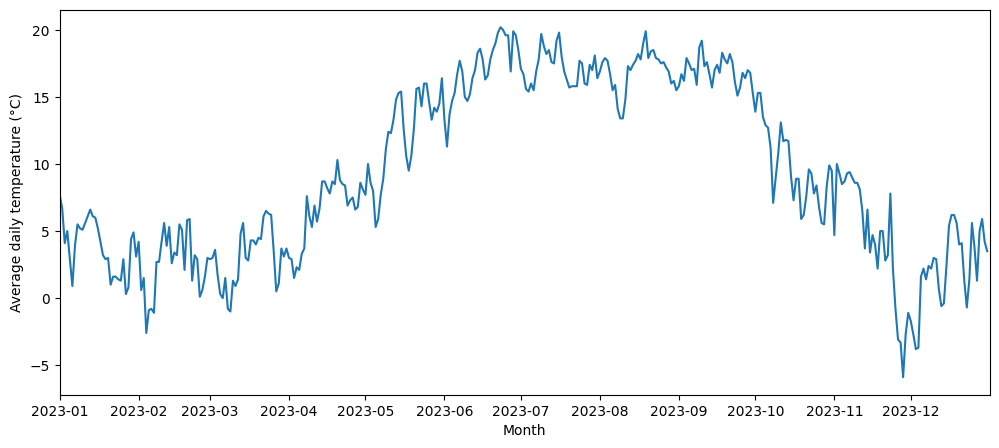

In [170]:
# Slicing 2023 rows
df_2023 = df.loc[112536:121295].copy()

# Add and group by date
df_2023['Date'] = df['Time'].dt.date
df_mean_2023 = df_2023.groupby('Date')['Lufttemperatur'].mean().round(1).reset_index()

# Create line diagram
fig = mpl.figure(figsize=(12, 5))
ax = fig.add_subplot()

# Adjust x-lim
ax.set_xlim(df_2023.iloc[0]['Time'], df_2023.iloc[-1]['Time'])

ax.plot(df_mean_2023['Date'], df_mean_2023['Lufttemperatur'])
ax.set_xlabel('Month')
ax.set_ylabel('Average daily temperature (°C)')
mpl.show()

***

### Part 4 (B)

Q10. Rank the overall temperature per two (2) consecutive months starting with the warmest 2-month period first, e.g., (Y1M1+Y1M2)/2, (Y1M2+Y1M3)/2,... (Y1M11+Y1M1)/2, (Y1M12+Y2M1)/2,.... After that, you should sort those means from highest to lowest and list the ten (10) warmest 2-month periods all together in the dataset.

In [171]:
# Create a slice that includes all complete months
df_4 = df.loc[0:121295].copy()
df_4.set_index('Time', inplace=True)

# Calculate average temperature for each month
df_m_avg = df_4.groupby(pd.Grouper(freq='ME')).mean().reset_index()

# Calculate average temperature for past 2 months
df_m_avg['Two month average'] = df_m_avg['Lufttemperatur'].rolling(window=2).mean().round(1)

time_average = []
# Format a column to print for 2-month periods
for i, row in enumerate(df_m_avg.iterrows()):
    if i == 0:
        time_average.append('2010: 2/3 - N')
        continue
    year_start = df_m_avg.iloc[i-1]['Time'].year
    year_end = row[1]['Time'].year
    month_start = calendar.month_name[df_m_avg.iloc[i-1]['Time'].month]
    month_end = calendar.month_name[row[1]['Time'].month]
    average = str(df_m_avg['Two month average'].iloc[i])
    time_average.append('{:<s}/{:<5d}- {:>6s}/{:<4d}: {:s}'.format(month_start, year_start, month_end, year_end, average))
            
df_m_avg.insert(0, 'Time and average', time_average, True)

# Sort values and print
df_m_avg = df_m_avg.sort_values('Two month average',ascending=False).reset_index(drop=True)
print("Warmest 2-month periods (°C):")
print(df_m_avg['Time and average'].head(10).to_string(index=False))

Warmest 2-month periods (°C):
July/2018 - August/2018: 20.8
June/2018 -   July/2018: 19.8
June/2021 -   July/2021: 19.5
July/2014 - August/2014: 19.3
July/2010 - August/2010: 18.9
July/2021 - August/2021: 18.7
July/2022 - August/2022: 18.5
July/2019 - August/2019: 18.4
July/2013 - August/2013: 18.3
June/2014 -   July/2014: 18.1


***

### Part 5 (A)

Q11. Calculate the 95% confidence intervals (CI) for the mean of each daily average in Q9 and add it to the line plot that shows the mean values of
each day of the year 2023. You can, for example, solve this by plotting the upper and lower bounds as lines above and below the mean line in your
plot. Another more nicely looking solution is to visualize the CI as shades around the mean line in your plot.

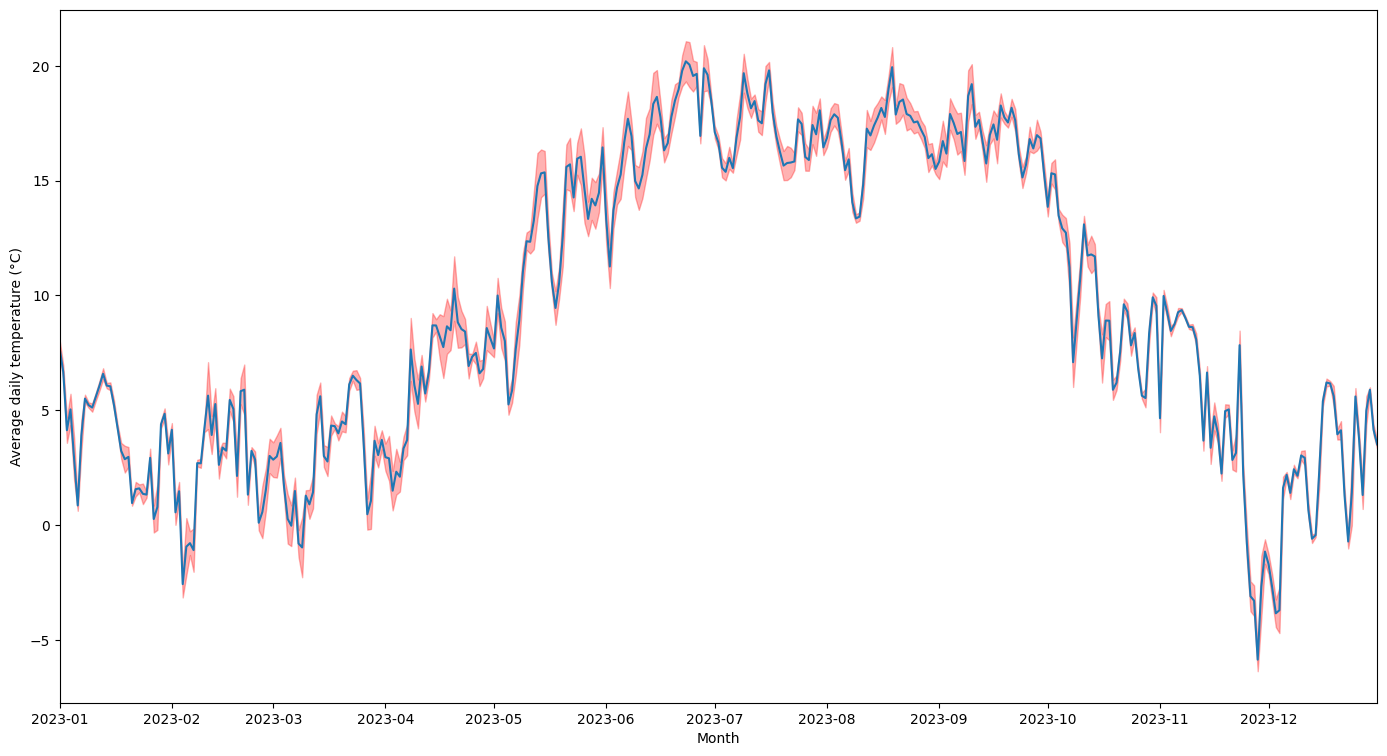

In [172]:
# Slice 2023
df_2023 = df.loc[112536:121295].copy()

# Group by date, with mean and std columns
df_2023['Time'] = df['Time'].dt.date
df_2023_group = df_2023.groupby('Time').agg(['mean','std']).droplevel(axis=1, level=0).reset_index()

# Calculate confidence intervals for each row
t_value = stats.t.ppf(0.05 / 2, 23)
df_2023_group['ci'] = abs(t_value*df_2023_group['std']/24**0.5)
df_2023_group['ci_low'] = df_2023_group['mean']-df_2023_group['ci']
df_2023_group['ci_high'] = df_2023_group['mean']+df_2023_group['ci']

# Create line diagram with confidence intervals
fig = mpl.figure(figsize=(17, 9))
ax = fig.add_subplot()

# Adjust x-lim
ax.set_xlim(df_2023.iloc[0]['Time'], df_2023.iloc[-1]['Time'])

ax.set_xlabel('Month')
ax.set_ylabel('Average daily temperature (°C)')
ax.plot(df_2023_group['Time'], df_2023_group['mean'])
ax.fill_between(df_2023_group['Time'], df_2023_group['ci_low'], df_2023_group['ci_high'], color='r', alpha=.3)
mpl.show()